# ThermalShift experiments notebook

## import...

In [1]:
#loading
import os, glob, re
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy import stats
import tifffile as tif
import tqdm 
import glob
import csv
import matplotlib as mpl
import matplotlib.ticker as ticker


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": "Ubuntu",
    "mathtext.fontset": "cm",
    "figure.dpi": 300,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "axes.linewidth": 1.5,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.6,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "lines.linewidth": 2.0,
    "legend.fontsize": 10,
    "legend.frameon": False,
    "image.cmap": "viridis"
})

## Local functions 

In [2]:
def load_full_data(path, magnification):
    """
    Load infos from metadatas.csv and files in folder saved in *.tif (stacked)
    
    return: 
    stacked_files_init (3d, array), images
    res_power (array), timings if T-stack, Powers if P-stack
    mydict (dictionnary), metadatas
    """

    mydict = 0
    
    with open(os.path.join(path,'metadatas.csv'), mode='r') as infile:
        reader = csv.reader(infile)
        #with open('metadatas_new.csv', mode='w') as outfile:
            #writer = csv.writer(outfile)
        mydict = {rows[0]:rows[1] for rows in reader}

    sizefiles = len(glob.glob1(path,"*.tif"))

    if sizefiles > 1:
        listfiles = glob.glob1(path,"*.tif")#sorted(glob.glob1(path,"*.tif"),key = lambda x:float(re.findall("(\d+)",x)[0]))
    else:
        listfiles = glob.glob1(path,"*.tif")
    print(listfiles)
    if mydict['3D_stack'] == 'no':
        stacked_files_init = io.imread(os.path.join(path, listfiles[0]))
        get_max = np.zeros(np.shape(stacked_files_init[:,:,0]))
    else:
        [nz,nx,ny] = np.shape(io.imread(os.path.join(path, 'sub1.tif')))
        #get_max = np.zeros(np.shape(stacked_files[:,:,0]))
        sizefiles = len(glob.glob1(data_directory,"*.tif"))

    if mydict['stack_mode'] == ' T':   
        res_power = np.linspace(0,float(mydict['fulltime']),int(mydict['totalframes']))
        res_power = res_power[:np.shape(stacked_files_init)[0]]
    
    return stacked_files_init, res_power, mydict



    
    
# --- Models ---
def Gauss(x, a, x0, sigma):  # For profile fitting
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Gauss_prop(z, w0, z0, C):  # Gaussian beam propagation
    λ = 1.035  # in µm
    n = 1.33
    return w0 * np.sqrt(1 + ((z - z0) * λ / (np.pi * n * w0 ** 2)) ** 2) + C


def timeValue(time,t0,A):
    return A*(1-np.exp(-(time)/t0))

# --- Waist Calculation ---
def compute_waist(y):  # At 1/e^2
    threshold = np.max(y) / np.exp(2)
    indices = np.where(y >= threshold)[0]
    return np.ptp(indices)



def extract_y0(data_dir, magnification):
    """
    Load or compute y0 data from .tif stacks.
    """
    try:
        y0_fin = np.load(os.path.join(data_dir, "y_fit2025.csv.npy"))
        res_power = np.loadtxt(os.path.join(data_dir, 'res_power.csv'))
    except Exception as e:
        print(f"Data missing: {e} — computing from raw stacks.")
        stacked_files, res_power, mydict = load_full_data(data_dir, magnification)
        y0_fin = np.zeros(stacked_files.shape[0])
        for ii in range(len(stacked_files)):
            axis = 1
            profile = np.max(stacked_files[ii, :, :], axis=axis)
            smoothed = savgol_filter(profile, 30, 4)
            peak = np.argmax(smoothed)
            y0_fin[ii] = -peak if axis == 1 else peak

        np.save(os.path.join(data_dir, "y_fit2025.csv"), y0_fin)
    return y0_fin, res_power



def compute_rising_time(y0, res_power, conversion_factor,lim=400):
    """
    Fit the time curve and extract the 90% rising time and fit error.
    """
    x_ms = res_power[:] * 1000
    y_um = (y0[:] -y0[0]) / conversion_factor

    popt, pcov = curve_fit(timeValue, x_ms[:lim], y_um[:lim], p0=[1, 1], maxfev=10000)
    t_fit = timeValue(x_ms, *popt)
    t0_std = np.sqrt(np.diag(pcov))[0] * 1e-3  # Convert to seconds

    # Rising time: when curve reaches 90% of final value
    threshold = 0.9 * max(t_fit)
    idx_rise = np.where(t_fit >= threshold)[0][0]
    rising_time = res_power[idx_rise]  # in seconds

    return t_fit, y_um, rising_time, threshold, t0_std
    
    
    
def animation_test(ii):
    """
    To create an animation
    """
    temp = np.max(np.where(savgol_filter(np.max(stacked_files[ii,:,:],axis=0),300,4)==np.max(savgol_filter(np.max(stacked_files[ii,:,:],axis=0),300,4))))
    ax1.clear()
    ax1.plot(res_power[:ii]*1000,(y0_fin[:ii]-y0_fin[0])*1/conversion_factor,color='black',alpha=0.6)
    #ax1.scatter(res_power[ii]*1000,-(y0_fin[ii]-y0_fin[0])*1/conversion_factor,s=8,color='red')
    ax1.set_ylabel('Along propagation axis (µm)')
    ax1.set_xlabel('Time (ms)')
    ax1.set_title('time={}ms'.format(np.round(res_power[ii]*1000,2)))
    ax2.clear()
    ax2.axvline(temp-300,ymin=0,ymax=20,color='red')
    ax2.imshow(stacked_files[ii,:,300:-300],cmap='Greys_r')
    
    ax2.set_ylabel('Pixels')
    ax2.set_xlabel('Pixels')
    

    inset1.clear()
    inset1.plot(np.max(stacked_files[ii,:,:],axis=0),color='green',alpha=0.3, label='Raw data')
    inset1.plot(savgol_filter(np.max(stacked_files[ii,:,:],axis=0),300,4),label='Filtered')
    inset1.scatter(temp,savgol_filter(np.max(stacked_files[ii,:,:],axis=0),300,4)[temp],s=8,color='red')
    plt.setp(inset1, xticks=[], yticks=[])


## Steady stade calculations

### With Power 

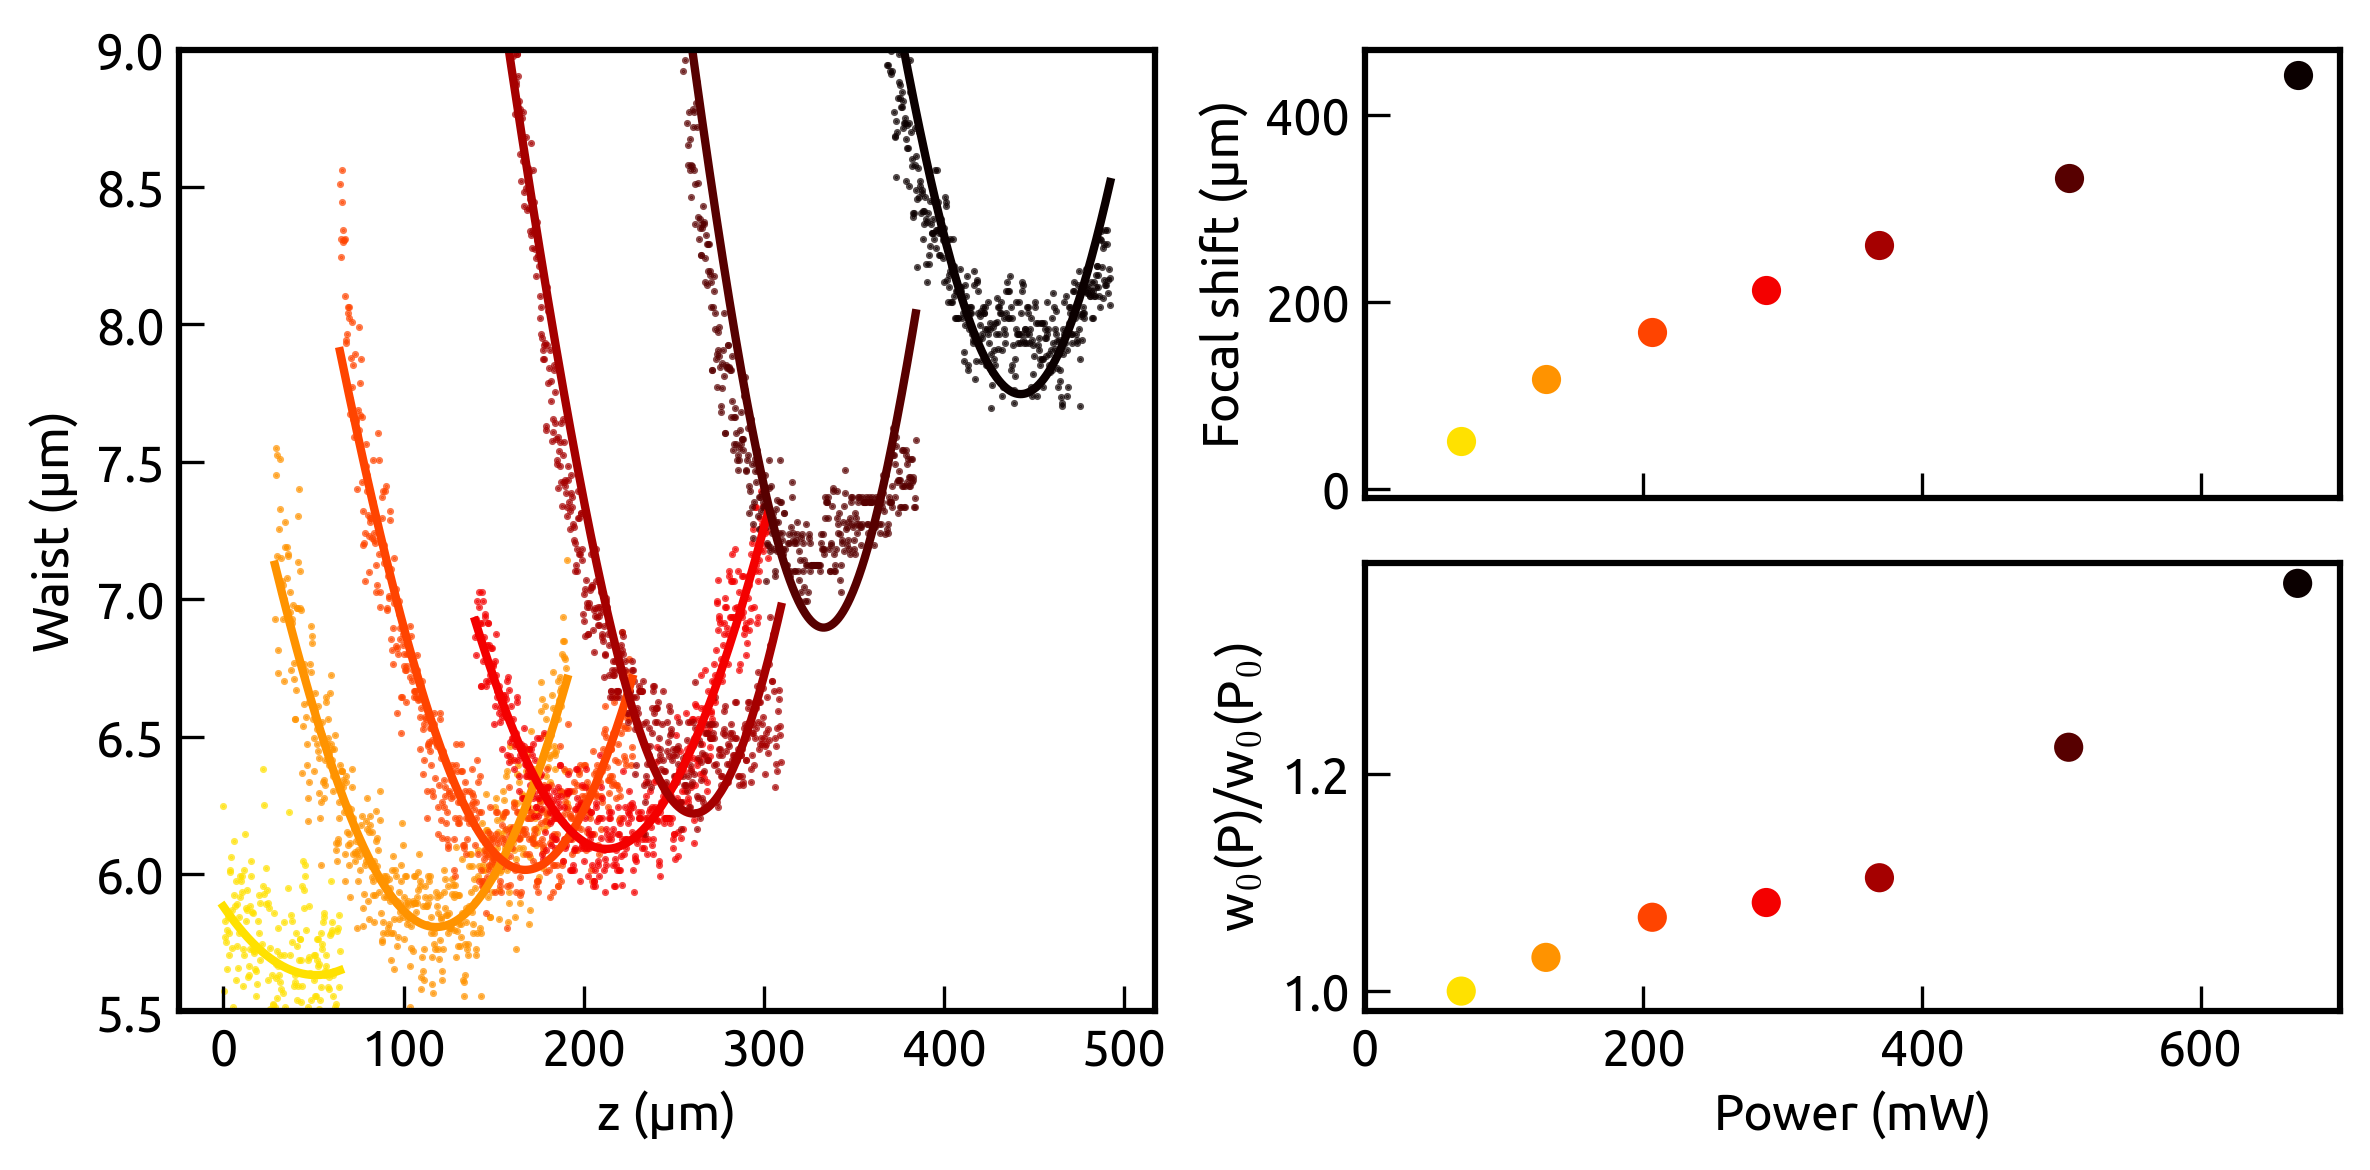

In [3]:
# --- Constants & Setup ---
data_directory = "dataset/z01/Pstack/"
conversion_factor = 20 / 6.5  # Magnification / camera pixel size
real_start = 0  # Will be updated dynamically


# --- Load Data ---
res_power = np.genfromtxt(os.path.join(data_directory, 'dataspowers.csv'), delimiter=';')
angle, res_power = res_power[:, 0], res_power[:, 1]

# --- Load y_fit or build it ---
try:
    y_fit = np.load(os.path.join(data_directory, "y_fit2025_1.npy"))
except FileNotFoundError:
    print("Computing y_fit from raw .tif stacks...")
    file_list = sorted(glob.glob(os.path.join(data_directory, '*.tif')), key=lambda x: float(re.findall(r"\d+", x)[0]))
    first_stack = io.imread(file_list[0])
    num_stacks, nx, ny = len(file_list), *first_stack.shape[1:]
    y_fit = np.zeros((num_stacks, nx, ny), dtype=np.float16)

    for i, file in enumerate(file_list):
        stack = io.imread(file)
        max_slice_idx = np.argmax(np.std(stack, axis=(1, 2)))
        y_fit[i] = stack[max_slice_idx]
        if i % 2 == 0:
            print(f"Processed {i+1}/{num_stacks}")

    np.save(os.path.join(data_directory, "y_fit2025_1.npy"), y_fit)


waists = np.zeros(y_fit.shape[:2])
for i in range(y_fit.shape[0]):
    for j in range(y_fit.shape[1]):
        profile = y_fit[i, j] - np.mean(y_fit[i, j, :30])
        #profile -= np.min(profile)
        waists[i, j] = np.sqrt(2) * compute_waist(profile) / 2

# --- Filter Unusable Stacks ---
bad_frames = []
for i in range(waists.shape[0]):
    nan_ratio = np.mean((waists[i] < 2) | (waists[i] > 150))
    if nan_ratio > 0.8:
        bad_frames.append(i)
real_start = len(bad_frames)

# --- Track waist along propagation axis ---
waist_memory = np.copy(waists)
waist_memory[(waists < 2) | (waists > 150)] = np.nan
z_axis_um = np.linspace(0, waists.shape[1]-1, waists.shape[1]) / conversion_factor
waist_prop = [waist_memory[i] / conversion_factor for i in range(real_start, waists.shape[0])]

# --- Fit Gaussian propagation & store focal shifts ---
get_max_pos = []
waist_positions = []
fit_waist_values = []
x_fit_values = []
y_fit_data_values = []

colors = plt.cm.hot(np.linspace(0, 0.7, len(waist_prop)))

for i, waist_profile in enumerate(waist_prop):
    idx = real_start + i
    min_idx = np.nanargmin(waist_profile)
    if idx == 0:
        x_shift = 100
    else:
        x_shift = 250
    #x_fit = np.arange(-x_shift, x_shift) / conversion_factor
    x_fit = np.arange(0, 2*x_shift) / conversion_factor
    y_fit_data = waist_profile[min_idx - x_shift:min_idx + x_shift]

    try:
        popt, _ = curve_fit(Gauss_prop, x_fit, y_fit_data, p0=[np.min(y_fit_data), 0, 1])
        w_fit = Gauss_prop(x_fit, *popt)
        focal_shift = x_fit[np.argmin(w_fit)] + z_axis_um[min_idx]
        fit_waist_values.append(w_fit)
        waist_positions.append(focal_shift)
        get_max_pos.append(z_axis_um[min_idx])
        x_fit_values.append(x_fit)
        y_fit_data_values.append(y_fit_data)
    except:
        print(f"Fit failed for idx {i}")
        continue

        
# --- Plotting ---
fig = plt.figure(figsize=(8,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224,sharex=ax2)


# Plot data and associated fit
for i in range(0,len(y_fit)):
    #ax1.scatter(z_axis_um-get_max_pos[0]+np.mean(x_fit_values[i]), waists[i],color=colors[-1-i],alpha=0.2)
    ax1.scatter(x_fit_values[i]+get_max_pos[i]-get_max_pos[0], savgol_filter(y_fit_data_values[i],5,3),color=colors[-1-i],alpha=0.7,s=0.5)
    ax1.plot(x_fit_values[i]+get_max_pos[i]-get_max_pos[0], fit_waist_values[i],color = colors[-1-i])
    
    
    # Plot focal shift vs power
    ax2.scatter(res_power[i],x_fit_values[i][np.argmin(fit_waist_values[i])]+get_max_pos[i]-get_max_pos[0],color=colors[-1-i])


ax1.set_xlabel("z (µm)")
ax1.set_ylabel("Waist (µm)")
ax1.set_ylim(5.5, 9)


ax2.set_ylabel('Focal shift (µm)')
ax2.tick_params('x', labelbottom=False)
ax2.set_ylim(-10,470)

# Waist normalization for plot 
waist_ratios = [min(fit_waist_values[i]) / min(fit_waist_values[0]) for i in range(0,len(fit_waist_values))]
ax3.scatter(res_power[real_start:], waist_ratios, c=np.flip(colors, 0))
ax3.set_ylabel('w$_0$(P)/w$_0$(P$_0$)')
ax3.set_xlabel('Power (mW)')
ax3.set_xlim(0, 700)

# Annotations
#fig.text(0.02, 0.95, "B", weight="bold")
#fig.text(0.48, 0.95, "C", weight="bold")
#fig.text(0.75, 0.95, "D", weight="bold")

plt.tight_layout()
# plt.savefig("thermal_lens_analysis.pdf")
plt.show()


### With z0

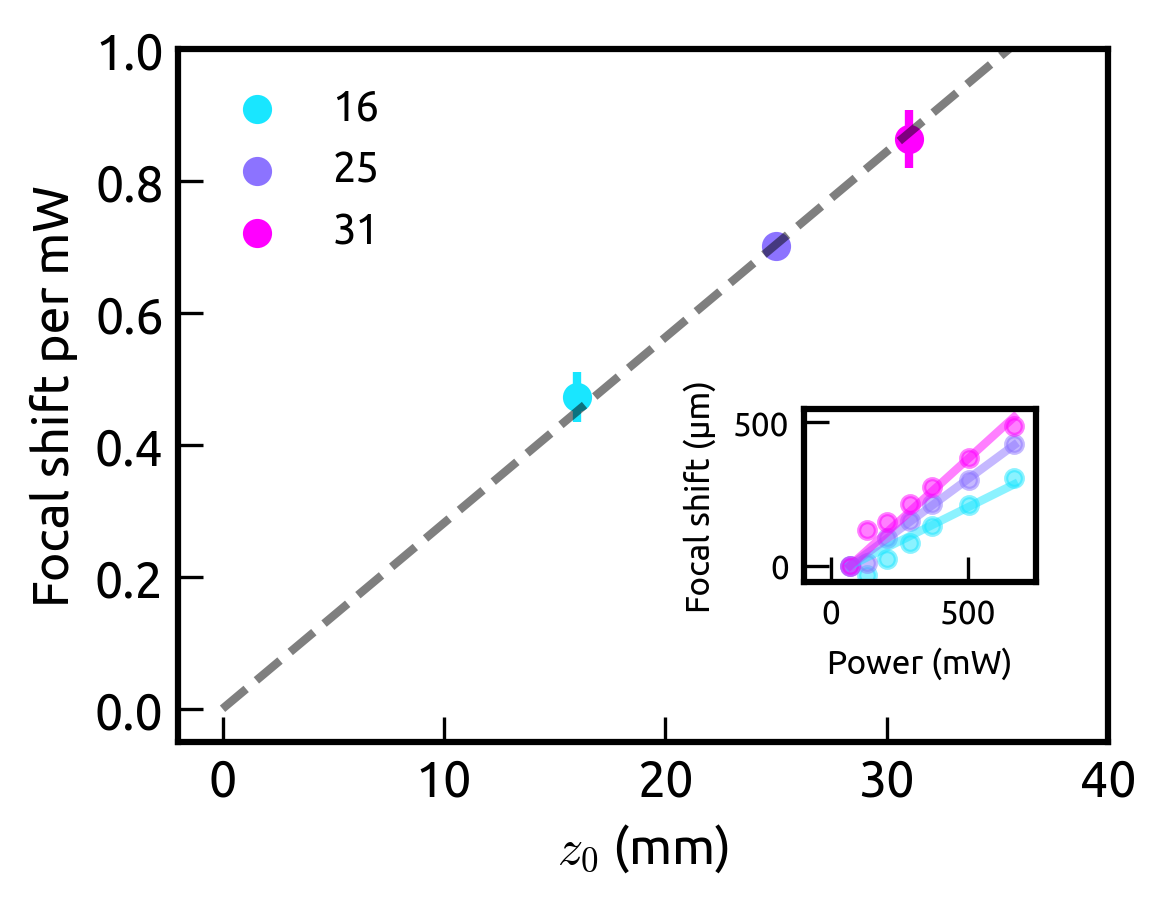

In [4]:
# ========== Plot Setup ==========

fig, ax2 = plt.subplots(figsize=(4, 3))  # Main plot: slope vs z0

# Inset plot inside ax2 for focal shift vs power
ax1 = inset_axes(
    ax2, width="50%", height="50%",
    bbox_to_anchor=(0.65, 0.01, 0.5, 0.5),
    bbox_transform=ax2.transAxes,
    loc='upper left'
)

# Set color map
colors = plt.cm.cool(np.linspace(0.1, 1, 3))

# ========== Metadata and Parameters ==========

data_directory = 'dataset/'
z0_folders = ['z01', 'z02', 'z03']
data_folder = 'Pstack'
z0_list = np.round([16, 25, 31])
magnification = 20
pixel_cam = 6.5  # µm/px
conversion_factor = magnification / pixel_cam  # px/µm

# ========== Main Loop Over z0 Conditions ==========

slope_tot = np.zeros(len(z0_list))
for kk, z0_folder in enumerate(z0_folders):
    # Load data paths and metadata
    data_path = os.path.join(data_directory + z0_folder, data_folder)
    files_power = sorted(glob.glob(data_path + '/*.tif'))
    res_power = np.loadtxt(os.path.join(data_path, 'res_power.csv'))
    power_used = np.zeros(np.shape(files_power))
    files = []
    try:
        y0_fin = np.load(os.path.join(data_path,"y_fit.csv.npy"))
        for kkk in range(0,len(y0_fin)):
            if kkk == 0:
                y0_norm = y0_fin[kkk]
            ax1.scatter(res_power[kkk], (y0_fin[kkk]-y0_norm) / conversion_factor,
                        color = colors[kk], alpha=0.5, s=16)
    except:
        print('Computing from raw datas...')
        # Sorting the names
        for i,ev in enumerate(files_power):
            power_used[i] = int(os.path.basename(ev)[:-4])

        sorted_power_used = np.int_(np.sort(power_used))
        for i,ev in enumerate(sorted_power_used):
            files.append(data_path+'/'+str(ev)+'.tif')
        # Read metadata
        with open(os.path.join(data_path, 'metadatas.csv'), 'r') as f:
            meta = {row[0]: row[1] for row in csv.reader(f)}


        # Extract focal position from each image
        y0_fin = np.zeros(len(files))
        for kkk, file in enumerate(files):
            img = io.imread(file)
            profile = np.max(img, axis=0)
            smoothed = savgol_filter(np.max(profile, axis=1), 30, 4)
            peak_pos = np.argmax(smoothed)
            y0_fin[kkk] = peak_pos

            # Normalize and plot
            if kkk == 0:
                y0_norm = peak_pos
            ax1.scatter(res_power[kkk], (peak_pos - y0_norm) / conversion_factor,
                        color=colors[kk], alpha=0.5, s=16)
        np.save(os.path.join(data_path,"y_fit.csv.npy"),y0_fin)

    
    # Linear fit with forced intercept at x0
    x = np.array(res_power)
    y = (y0_fin - y0_norm) / conversion_factor
    x0 = x[0]
    x_shifted = x - x0

    slope, _, _, _ = np.linalg.lstsq(x_shifted[:, np.newaxis], y, rcond=None)
    y_pred = slope * x_shifted
    residuals = y - y_pred

    # Compute standard error
    res_var = np.sum(residuals**2) / (len(x) - 1)
    std_err = np.sqrt(res_var / np.sum(x_shifted**2))

    # Plot fit and slope
    ax1.plot(x, y_pred, color=colors[kk], alpha=0.5)
    ax2.scatter(z0_list[kk], slope, color=colors[kk])
    ax2.errorbar(z0_list[kk], slope, yerr=std_err, color=colors[kk])
    slope_tot[kk] = slope[0]

# ========== Final Plot Settings ==========

# Inset plot (focal shift vs power)
ax1.set_xlabel('Power (mW)', fontsize=8)
ax1.set_ylabel('Focal shift (µm)', fontsize=8)
ax1.tick_params(axis='both', labelsize=8)
ax1.set_xlim([-100, 750])

# Main plot (slope vs z0)
ax2.set_xlabel('$z_0$ (mm)')
ax2.set_ylabel('Focal shift per mW')
ax2.set_xlim([-2, 40])
ax2.set_ylim([-0.05, 1])
ax2.legend(z0_list, fontsize='medium')

# Fit and overlay global slope trend
global_slope, _, _, _ = np.linalg.lstsq(z0_list[:, np.newaxis], slope_tot, rcond=None)
xfit = np.linspace(0, 40, 40)
ax2.plot(xfit, global_slope * xfit, linestyle='--', color='k', alpha=0.5)

# Show result
plt.show()


## Temporal 

### Temporal z_0 change

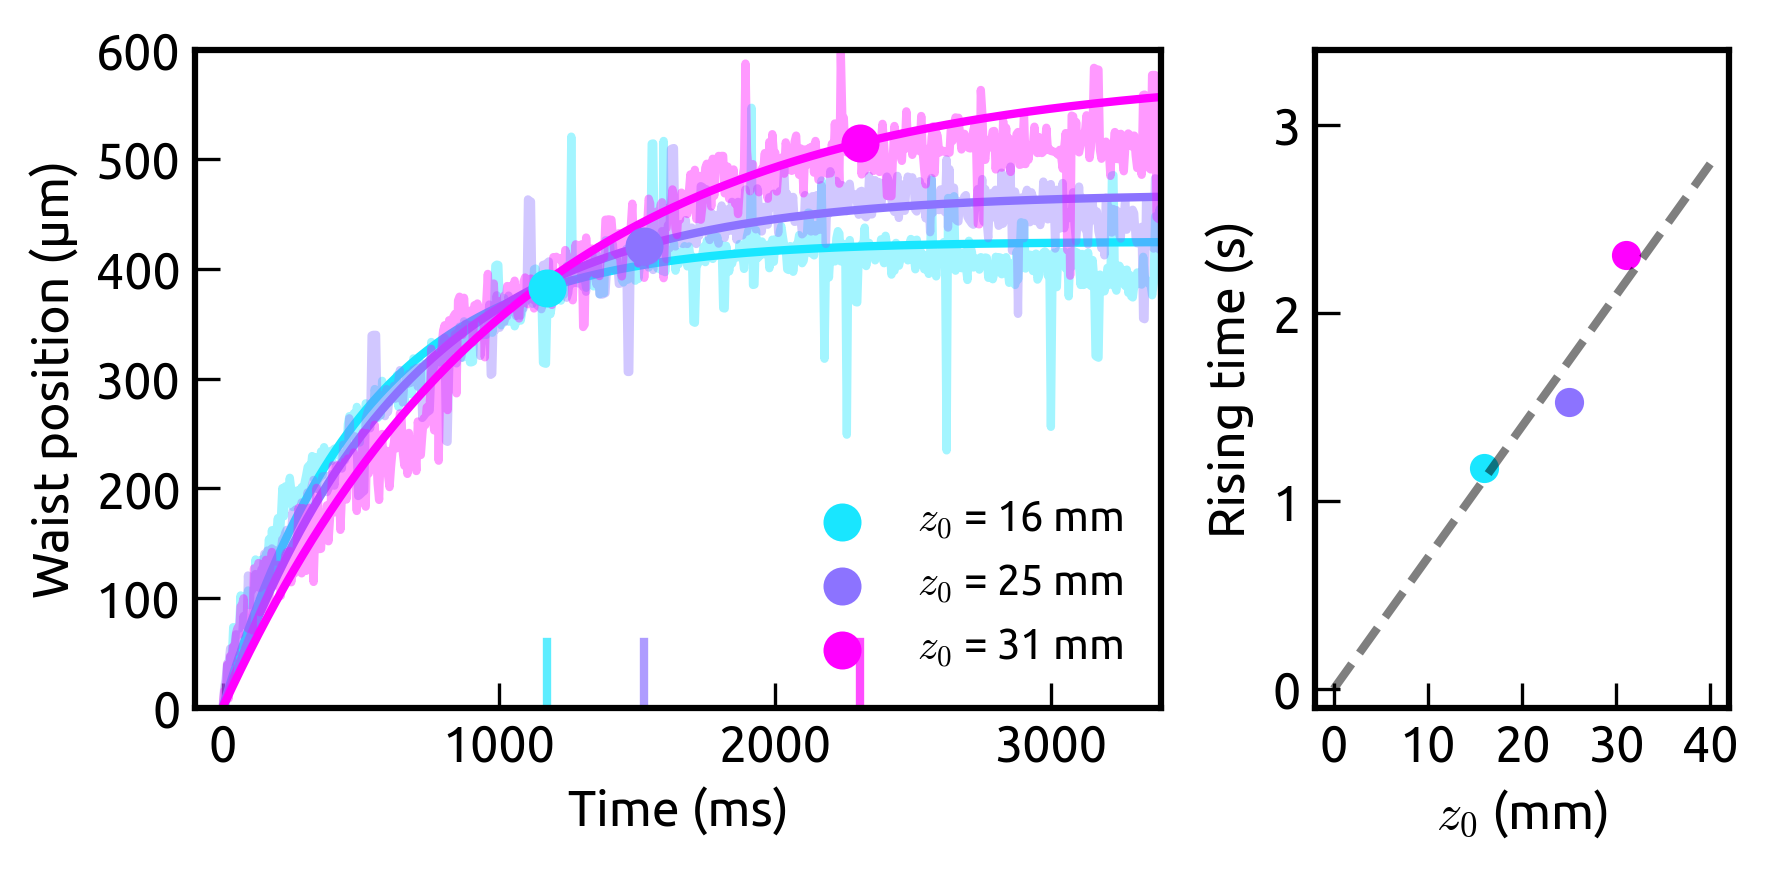

In [5]:
# ---------- Experimental Setup ----------
data_directory = 'dataset/'
z0_list = np.array([16, 25, 31])
z0_folders = ['z01', 'z02', 'z03']
data_folders = ['Tstack30', 'Tstack40', 'Tstack100']
power_list = [206.46, 369.52, 669.6]  # experimental power
colors = plt.cm.cool(np.linspace(0.1, 1, len(z0_list)))

magnification = 20
pixel_size = 6.5  # µm
conversion_factor = magnification / pixel_size  # px to µm

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3),sharey=False,width_ratios=[0.7,0.3])
# ----- Loop through folders -----
slope_tot = []
for kk, z0 in enumerate(z0_folders):
    data_dirr = os.path.join(data_directory + z0, data_folders[2])
    y0_fin, res_power = extract_y0(data_dirr, magnification)

    # Fit and compute rising time
    t_fit, y_um, rise_t, y90, t0_err = compute_rising_time(y0_fin, res_power, conversion_factor)
    maxsize = min(len(y0_fin), len(res_power))
    # --- Plotting ---
    ax1.plot(res_power[:maxsize]*1000, t_fit[:maxsize], color=colors[kk])
    ax1.plot(res_power[:maxsize]*1000, y_um[:maxsize], alpha=0.4, color=colors[kk])
    ax1.scatter(rise_t * 1000, y90, color=colors[kk], s=66, label=f'$z_0$ = {z0_list[kk]:.0f} mm',zorder=10)
    ax1.axvline(rise_t * 1000, ymin=0.0, ymax=0.1, color=colors[kk], alpha=0.7)

    ax2.scatter(z0_list[kk], rise_t, color=colors[kk])
    ax2.errorbar(z0_list[kk], rise_t, yerr=[[t0_err], [t0_err]], color=colors[kk], alpha=0.5)

    slope_tot.append(rise_t)
    
# ---------- Final Plot Formatting ----------
ax1.set_xlim([-100, 3400])
ax1.set_ylim([0, 600])
ax1.legend()
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Waist position (µm)')
ax2.set_xlabel('$z_0$ (mm)')
ax2.set_ylabel('Rising time (s)')
ax2.set_ylim([-0.1, 3.4])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))

# Linear fit across z0 values
slope, _, _, _ = np.linalg.lstsq(z0_list[:, np.newaxis], slope_tot, rcond=None)
fit_line = np.linspace(0, 40, 100)
ax2.plot(fit_line, slope * fit_line, linestyle='--', color='k', alpha=0.5)

fig.tight_layout()
plt.show()

### Temporal, Power change 

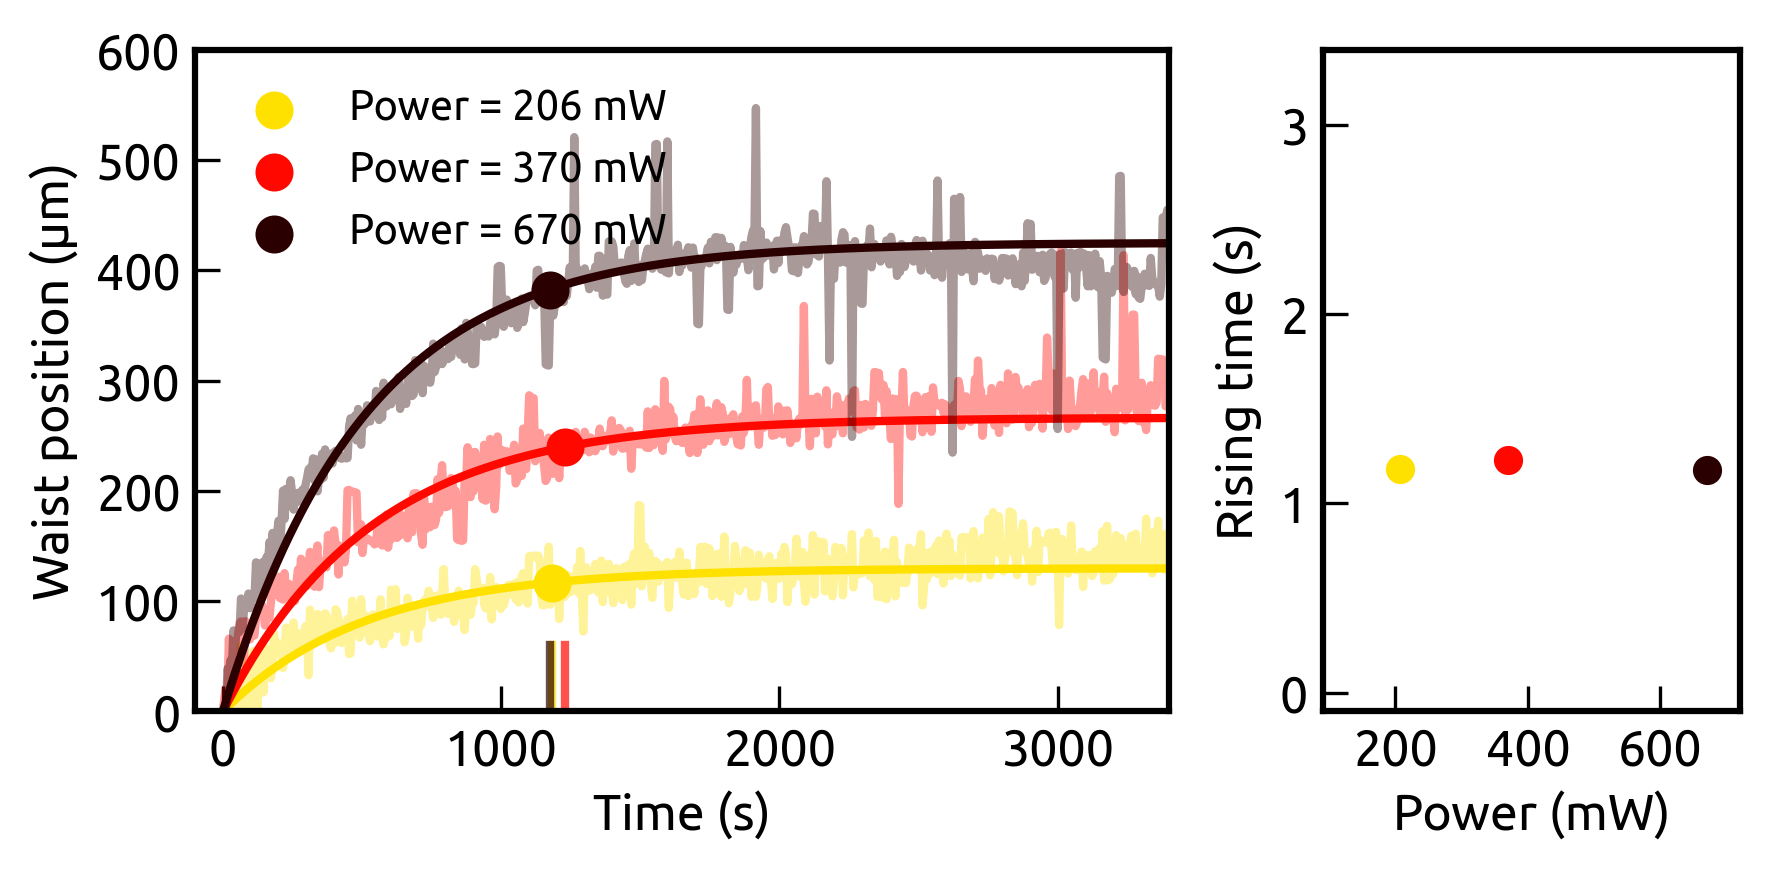

In [6]:
# ---------- Experimental Setup ----------
data_directory = "dataset/"
z0_list = np.array([16, 25, 31])
z0_folders = ['z01', 'z02', 'z03']
data_folders = ['Tstack30', 'Tstack40', 'Tstack100']
power_list = [206.46, 369.52, 669.6]  # experimental power
colors = plt.cm.cool(np.linspace(0.1, 1, len(z0_list)))

magnification = 20
pixel_size = 6.5  # µm
conversion_factor = magnification / pixel_size  # px to µm

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3),sharey=False,width_ratios=[0.7,0.3])
colors = (plt.cm.hot(np.linspace(0.7, 0.05, 3)))
# ----- Loop through folders -----
slope_tot = []
for kk, power in enumerate(data_folders):
    data_dirr = os.path.join(data_directory + z0_folders[0], power)
    y0_fin, res_power = extract_y0(data_dirr, magnification)

    # Fit and compute rising time
    t_fit, y_um, rise_t, y90, t0_err = compute_rising_time(y0_fin, res_power, conversion_factor)
    maxsize = min(len(y0_fin), len(res_power))
    # --- Plotting ---
    ax1.plot(res_power[:maxsize]*1000, t_fit[:maxsize], color=colors[kk])
    ax1.plot(res_power[:maxsize]*1000, y_um[:maxsize], alpha=0.4, color=colors[kk])
    ax1.scatter(rise_t * 1000, y90, color=colors[kk], s=66, label=f'Power = {power_list[kk]:.0f} mW')
    ax1.axvline(rise_t * 1000, ymin=0.0, ymax=0.1, color=colors[kk], alpha=0.7)

    ax2.scatter(power_list[kk], rise_t, color=colors[kk])
    ax2.errorbar(power_list[kk], rise_t, yerr=[[t0_err], [t0_err]], color=colors[kk], alpha=0.5)

    slope_tot.append(rise_t)
    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Waist position (µm)')
ax1.set_xlim([-100,3400])
ax1.set_ylim(0,600)
ax2.set_ylim(-0.1,3.4)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_ylabel('Rising time (s)')
#ax2.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax2.set_xlabel('Power (mW)')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2.set_xlim(90,720)

#ax1.set_ylim(-10,50)
#ax1.set_xlim(-10,20)
ax1.legend()
fig.tight_layout()
plt.show()